# Carvana learning

## Подключение библиотек и загрузка датасета

In [1]:
!pip install segmentation_models_pytorch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import numpy as np
import glob
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 87 kB 3.4 MB/s 
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 376 kB 31.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bc992a4d56da6d5316456b5ce9604c469249e887bd99ae1ebf6618d9a70adf1e
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=da8888efa7af09026aebf7767b9d065e27320f27d82fc27a4ee320ec49cef559
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!kaggle competitions download -c carvana-image-masking-challenge
#!cp /content/test_hq.zip  /content/drive/MyDrive/carvana_dataset/
#!cp /content/train_hq.zip  /content/drive/MyDrive/carvana_dataset/
!cp /content/test.zip  /content/drive/MyDrive/carvana_dataset/
!cp /content/train.zip  /content/drive/MyDrive/carvana_dataset/
!cp /content/train_masks.zip /content/drive/MyDrive/carvana_dataset/
!cp /content/metadata.csv.zip /content/drive/MyDrive/carvana_dataset/
!cp /content/train_masks.csv.zip /content/drive/MyDrive/carvana_dataset/
!cp /content/sample_submission.csv.zip /content/drive/MyDrive/carvana_dataset/

In [3]:
#!cp /content/drive/MyDrive/carvana_dataset/test.zip   /content/
!cp /content/drive/MyDrive/carvana_dataset/train.zip   /content/
!cp /content/drive/MyDrive/carvana_dataset/train_masks.zip  /content/
!cp /content/drive/MyDrive/carvana_dataset/metadata.csv.zip  /content/
!cp /content/drive/MyDrive/carvana_dataset/train_masks.csv.zip  /content/
!cp /content/drive/MyDrive/carvana_dataset/sample_submission.csv.zip  /content/

In [ ]:
!unzip /content/train.zip -d /content/train
!rm -r /content/train.zip
#!unzip /content/test.zip -d /content/test
#!rm -r /content/test.zip
!unzip /content/train_masks.zip -d /content/train_masks
!rm -r /content/train_masks.zip
!unzip /content/train_masks.csv.zip -d /content/
!unzip /content/sample_submission.csv.zip -d /content/
!unzip /content/metadata.csv.zip -d /content/

## Используемые функции

In [5]:
def get_data_csv(imgs_path: str = None, masks_path: str = None) -> pd.DataFrame:
  '''Funtion gets images from imgs_path and masks from masks_path
  and generates pd.DataFrame, contains links to images and masks related 
  to a certain photo of car
  
  input parameters:
  string: imgs_path - path to folder with images,
  masks_path - path to folder with masks
  
  output parameters:
  pd.DataFrame: data - dataframe, contains links to images and masks'''

  assert (imgs_path != None) & (masks_path != None)
  # imgs_path or masks_path is equal None

  data_img = {}
  data_mask = {}
  data_img['imgs_path'] = []
  data_mask['masks_path'] = []
  data_img['imgs_path'] = list(glob.glob(imgs_path + "/*"))
  data_mask['masks_path'] = list(glob.glob(masks_path + "/*"))

  data_img = pd.DataFrame(data_img)
  data_mask = pd.DataFrame(data_mask)

  def file_name(x):
      return x.split("/")[-1].split(".")[0]

  data_img["file_name"] = data_img["imgs_path"].apply(lambda x: file_name(x))
  data_mask["file_name"] = data_mask["masks_path"].apply(lambda x: file_name(x)[:-5])

  data = pd.merge(data_img, data_mask, on = "file_name", how = "inner")

  return data

In [6]:
def get_train_test(source_df: pd.DataFrame, separate_feature: str = None, test_size: int = 0.25) -> pd.DataFrame:
  '''Function get source_df and split it on train and valid pd.DataFrame 
  with test_size coefficient. If separate_feature not None, splitting will 
  be on unique values of that feature

  input parameters:
  source_df: pd.DataFrame - datafraim that will be splitted

  separate_feature: str - datafraim will 
  be splitted on unique values of that feature

  test_size: int - splitting coefficient
  
  output parameters:
  pd.DataFrame: data - dataframe, contains links to images and masks'''
  
  if (separate_feature != None) & (separate_feature in source_df.columns):
    train_cars, valid_cars = train_test_split(data[separate_feature].unique(), test_size=test_size)
    data_valid = data[np.isin(data[separate_feature].values, valid_cars)]
    data_train = data[np.isin(data[separate_feature].values, train_cars)]
    assert data.shape[0] == (data_valid.shape[0] + data_train.shape[0])
    assert np.isin(data_train[separate_feature].values, data_valid[separate_feature].values).sum() == 0
  else:
    data_train, data_valid = train_test_split(data, test_size=test_size)

  return data_train, data_valid


In [7]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

## Подготовка данных для обучения

### Генерация датафрейма со ссылками на изображения и маски

In [8]:
imgs_path  = '/content/train/train'
masks_path = '/content/train_masks/train_masks'

In [9]:
data = get_data_csv(imgs_path=imgs_path, masks_path=masks_path)
data.head()

,imgs_path,file_name,masks_path
0,/content/train/train/9ab2a45de8c7_09.jpg,9ab2a45de8c7_09,/content/train_masks/train_masks/9ab2a45de8c7_...
1,/content/train/train/424658d9f222_01.jpg,424658d9f222_01,/content/train_masks/train_masks/424658d9f222_...
2,/content/train/train/683ddec95b82_16.jpg,683ddec95b82_16,/content/train_masks/train_masks/683ddec95b82_...
3,/content/train/train/c9f382c7349e_08.jpg,c9f382c7349e_08,/content/train_masks/train_masks/c9f382c7349e_...
4,/content/train/train/48b3f0c936b5_09.jpg,48b3f0c936b5_09,/content/train_masks/train_masks/48b3f0c936b5_...


### Разбиение на train и valid

In [10]:
# Добавляем признак, по которому будем разбивать датасет на train и test,
# чтобы не было разных фотографий одной и той же машины в двух датасетах
data["car"] = data["file_name"].apply(lambda x: x.split('_')[0])
train_df, valid_df = get_train_test(data, separate_feature='car', test_size=0.25)

In [11]:
train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)

In [12]:
# Проверяем, что нет пересечений
np.isin(valid_df['car'].unique(), train_df['car'].unique()).sum()

0

### Класс для кастомного датасета

In [13]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,2]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (H, W, 3) -> (1, H, W, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, H, W, 3) -> (1, 3, H, W)
        img = img.unsqueeze(0).permute(0,3,1,2)

        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        mask = Image.open(self.label_arr[index]).convert('LA') # преобразование в серый
        mask = np.asarray(mask).astype('float')[:,:,0]
        mask = torch.as_tensor(np.where(mask > 100, 1.0, 0)).unsqueeze(0) # введение порога и нормализация
        mask = mask.unsqueeze(0)
        mask = mask.float()
        # делаем ресайз картинки на 256х256
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

In [14]:
train_data = CustomDatasetFromImages(train_df)
test_data = CustomDatasetFromImages(valid_df)

In [15]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=16,shuffle=False)

### Проверка работы загрузчика

In [16]:
loader = iter(train_data_loader)
img, mask = loader.next()

In [17]:
img.shape

torch.Size([1, 1, 3, 256, 256])

In [18]:
mask.shape

torch.Size([1, 1, 1, 256, 256])

In [19]:
torch.unique(mask[0])

tensor([0., 1.])

In [20]:
np.unique(img).min()

0.0

In [21]:
np.unique(img).max()

1.0

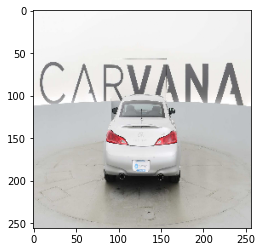

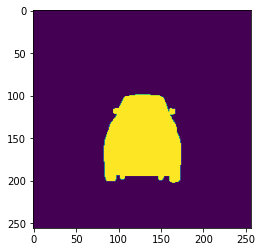

In [22]:
plt.imshow((img[0][0]).permute(1, 2, 0))
plt.show()
plt.imshow((mask[0][0][0]))
plt.show()

## Создание класса модели

In [23]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

## Обучение модели

In [24]:
learning_rate = 0.001
epochs = 1

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [26]:
# Создание своей модели
Umodel = UNet(num_classes=1).to(device)

In [27]:
# Создание модели из segmentation_models_pytorch
Umodel = smp.Unet('mobilenet_v2', 
                  classes=1, 
                  encoder_weights='imagenet').to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [28]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [29]:
criterion = SoftDiceLoss()

In [30]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 3808 total_steps per epoch


In [31]:
!nvidia-smi

Thu Sep 23 21:11:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    58W / 149W |    606MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Train Epoch: 1, Loss: 0.10321888248125712
Spend time for 300 images: 66.09701609611511 sec


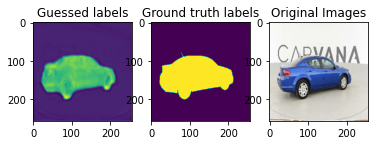

Train Epoch: 1, Loss: 0.020015328923861184
Spend time for 300 images: 66.53975415229797 sec


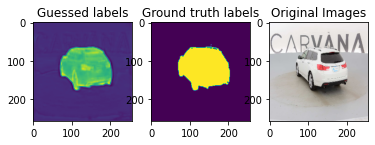

Train Epoch: 1, Loss: 0.02614509463310242
Spend time for 300 images: 66.88772964477539 sec


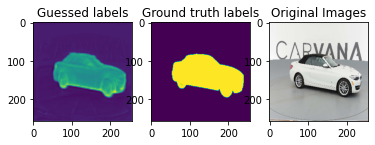

Train Epoch: 1, Loss: 0.01866153577963511
Spend time for 300 images: 66.36178016662598 sec


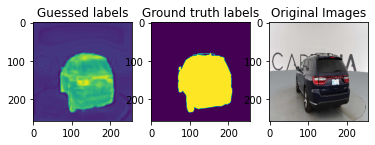

Train Epoch: 1, Loss: 0.015810783902804056
Spend time for 300 images: 66.52501940727234 sec


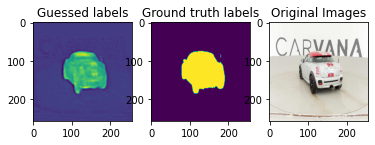

Train Epoch: 1, Loss: 0.013437022765477499
Spend time for 300 images: 66.39907813072205 sec


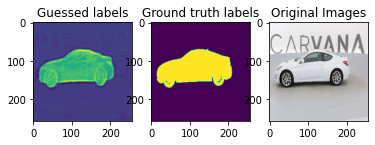

Train Epoch: 1, Loss: 0.011720330119132996
Spend time for 300 images: 66.5624589920044 sec


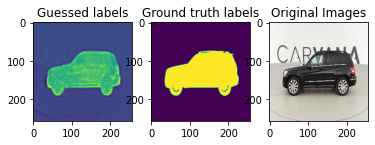

Train Epoch: 1, Loss: 0.011647990544637044
Spend time for 300 images: 66.40384531021118 sec


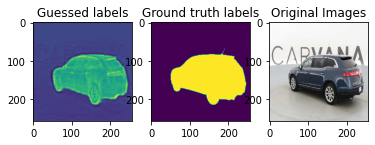

Train Epoch: 1, Loss: 0.01145619034767151
Spend time for 300 images: 66.36694574356079 sec


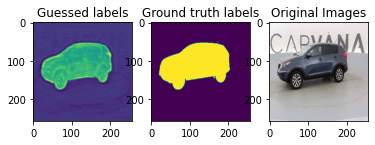

Train Epoch: 1, Loss: 0.01768394390741984
Spend time for 300 images: 66.81835746765137 sec


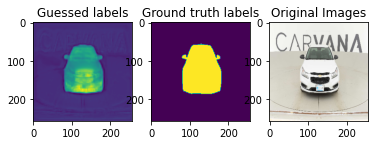

Train Epoch: 1, Loss: 0.012205978035926818
Spend time for 300 images: 66.32209324836731 sec


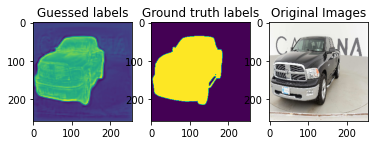

Train Epoch: 1, Loss: 0.01157912810643514
Spend time for 300 images: 65.77615451812744 sec


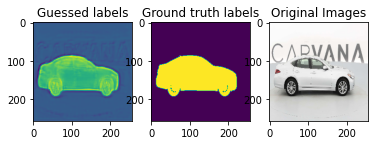

Epoch 1, loss:  0.022151091754311274


In [32]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0

            f, axarr = plt.subplots(1,3)
            #axarr[0].imshow(torch.argmax(outputs.detach().cpu().numpy()[0,:,:]))
            axarr[0].imshow(outputs.detach().cpu().numpy()[0, 0, :,:])
            axarr[0].set_title('Guessed labels')

            axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
            axarr[1].set_title('Ground truth labels')

            axarr[2].imshow(data[0].permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:])
            axarr[2].set_title('Original Images')
            plt.show()

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

In [33]:
# 1 эпоха - 15 минут